In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import funciones_analisis as funciones

In [7]:
# Leer los tres dataframes procesados desde la carpeta 'df_procesados'
df_planta_1 = pd.read_csv('../df_procesados/df_planta_1.csv')
df_planta_2 = pd.read_csv('../df_procesados/df_planta_2.csv')
df_planta_3 = pd.read_csv('../df_procesados/df_planta_3.csv')

In [8]:
df_planta_1['date_time'] = pd.to_datetime(df_planta_1['date_time'])
df_planta_2['date_time'] = pd.to_datetime(df_planta_2['date_time'])
df_planta_3['date_time'] = pd.to_datetime(df_planta_3['date_time'])

# Planta 1

In [9]:
res = funciones.detectar_drift_ks(df_planta_1, columnas=[col for col in df_planta_1.columns if col != "date_time"])

res

,variable,stat,pvalue,drift_detectado,detalle
0,Conductividad DAF,0.240414,0.000000e+00,True,ok
1,Flujo Parshall 01 entrada a Ecualizador 1,0.050784,2.200122e-46,True,ok
2,Flujo de envío a DAF,0.213864,0.000000e+00,True,ok
3,Nivel Ecualizador 1 (Tk 30m3),0.581472,0.000000e+00,True,ok
4,Nivel Ecualizador 2 (Tk 250m3),0.498100,0.000000e+00,True,ok
5,Temperatura DAF,0.000049,1.000000e+00,False,ok
6,pH Clarificado DAF (Tk 80m3),0.771483,0.000000e+00,True,ok
7,pH Ecualizador 2 (Tk 250m3),NaN,NaN,None,pocos datos
8,pH coagulación entrada DAF,0.214237,0.000000e+00,True,ok
9,pH entrada a Ecualizador 2 (Tk 250m3),0.724201,0.000000e+00,True,ok


## Ventanas de Proceso Activo

In [10]:
FECHA = "date_time"

# ---------------------------
# 1) Bandera de "proceso activo"
# ---------------------------
def build_active_flag(
    df: pd.DataFrame,
    fecha_col: str,
    rules: dict,
    smooth_window: int = 15,       # ~15 min si tienes dato por minuto
    min_block_len: int = 10        # descarta bloques < 10 muestras
) -> pd.Series:
    """
    rules: diccionario {nombre_variable: {"op": ">", "thr": valor}} o {"op": "diff>", "thr": valor}
           Soporta:
             - ">"  : variable > thr
             - "<"  : variable < thr
             - "diff>" : |diff(variable)| > thr  (movimiento)
    """
    df2 = df.copy()
    df2[fecha_col] = pd.to_datetime(df2[fecha_col])
    df2 = df2.sort_values(fecha_col)

    conds = []
    for col, spec in rules.items():
        op = spec.get("op", ">")
        thr = spec.get("thr", 0)
        if col not in df2.columns:
            continue
        s = df2[col]
        if op == ">":
            c = s > thr
        elif op == "<":
            c = s < thr
        elif op == "diff>":
            c = s.diff().abs() > thr
        else:
            raise ValueError(f"Operador no soportado: {op}")
        conds.append(c.fillna(False))

    if not conds:
        return pd.Series(False, index=df2.index, name="proceso_activo")

    raw = np.logical_or.reduce(conds)

    # Suavizado para evitar parpadeos (cierre morfológico sencillo)
    smooth = pd.Series(raw, index=df2.index).rolling(smooth_window, min_periods=1).max().astype(bool)

    # Enforce min_block_len: elimina bloques muy cortos (ruido)
    flag = smooth.copy()
    run_start = None
    for i, v in enumerate(flag.values):
        if v and run_start is None:
            run_start = i
        if (not v or i == len(flag)-1) and run_start is not None:
            end = i if not v else i  # cierre
            length = end - run_start + (1 if v and i == len(flag)-1 else 0)
            if length < min_block_len:
                flag.iloc[run_start:end] = False
            run_start = None

    flag.name = "proceso_activo"
    return flag

# ---------------------------
# 2) Bloques (start, end) desde la bandera
# ---------------------------
def blocks_from_flag(df: pd.DataFrame, fecha_col: str, flag: pd.Series) -> pd.DataFrame:
    df2 = df.copy()
    df2[fecha_col] = pd.to_datetime(df2[fecha_col])
    df2 = df2.sort_values(fecha_col)
    f = flag.reindex(df2.index).fillna(False).values

    starts, ends = [], []
    in_block = False
    for i, v in enumerate(f):
        if v and not in_block:
            starts.append(df2[fecha_col].iloc[i])
            in_block = True
        if not v and in_block:
            ends.append(df2[fecha_col].iloc[i-1])
            in_block = False
    if in_block:
        ends.append(df2[fecha_col].iloc[-1])

    return pd.DataFrame({"start": starts, "end": ends})

# ---------------------------
# 3) Graficar con sombreado de ventanas activas
# ---------------------------
def plot_with_active_blocks(
    df: pd.DataFrame,
    fecha_col: str,
    col: str,
    blocks: pd.DataFrame,
    resample: str = "15min",
    color: str = "tab:red",
    alpha: float = 0.18,
    show_points: bool = False
):
    df2 = df[[fecha_col, col]].dropna().copy()
    df2[fecha_col] = pd.to_datetime(df2[fecha_col])
    df2 = df2.sort_values(fecha_col)

    if resample is not None:
        s = (df2.set_index(fecha_col)[col]
                .resample(resample).median().dropna().reset_index())
    else:
        s = df2.rename(columns={col: "value"}).rename(columns={"value": col})

    plt.figure(figsize=(12, 4))
    if show_points:
        plt.plot(s[fecha_col], s[col], marker='.', linestyle='None', markersize=2)
    else:
        plt.plot(s[fecha_col], s[col])

    for _, r in blocks.iterrows():
        plt.axvspan(pd.to_datetime(r["start"]), pd.to_datetime(r["end"]), color=color, alpha=alpha)

    plt.title(f"Serie de tiempo – {col} (ventanas ACTIVAS sombreadas)")
    plt.xlabel("Tiempo"); plt.ylabel(col); plt.tight_layout(); plt.show()


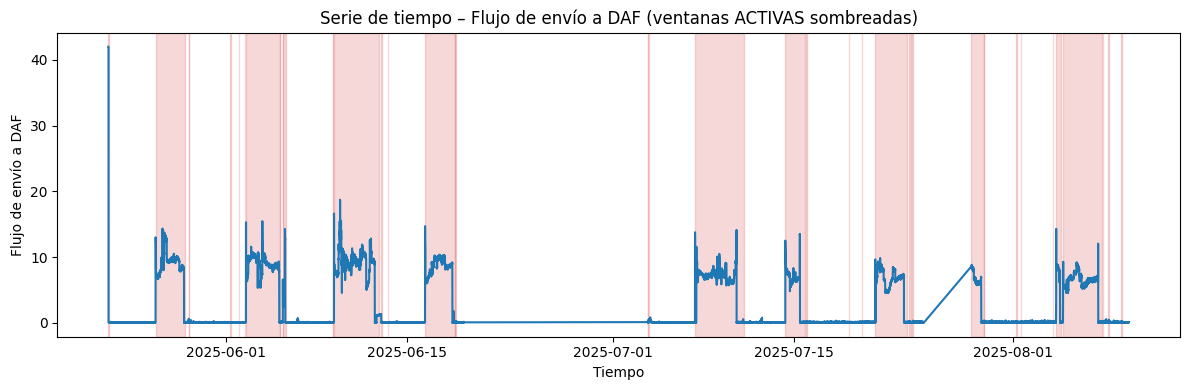

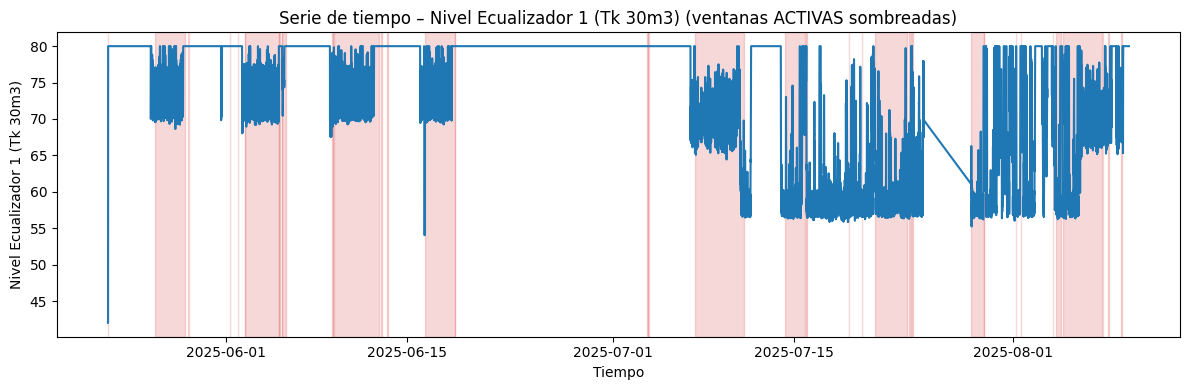

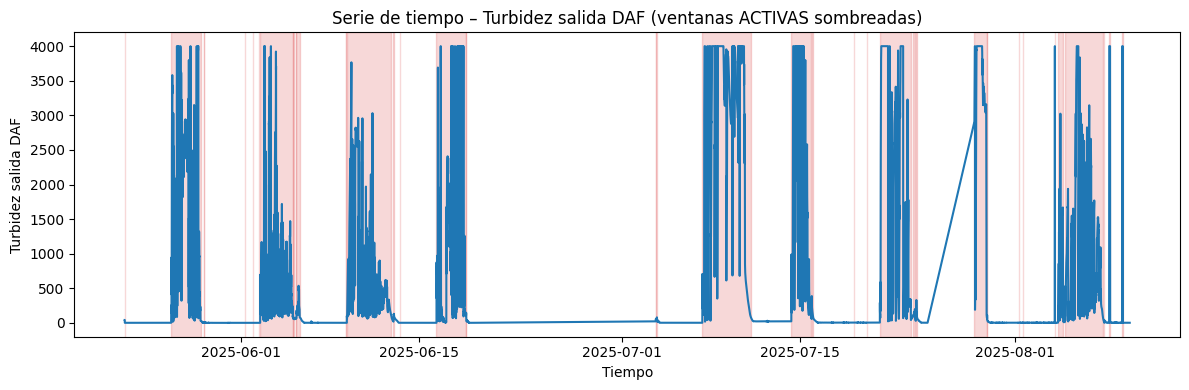

In [11]:
df = df_planta_1.copy()
df[FECHA] = pd.to_datetime(df[FECHA])

# Reglas de activación (OR entre reglas)
rules = {
    "Flujo de envío a DAF": {"op": ">", "thr": 2},
    "Turbidez salida DAF": {"op": ">", "thr": 100},
    "Nivel Ecualizador 2 (Tk 250m3)": {"op": "diff>", "thr": 1.0},  # movimiento
}

flag = build_active_flag(df, FECHA, rules, smooth_window=15, min_block_len=10)
blocks_activos = blocks_from_flag(df, FECHA, flag)

# Ver rápidamente si marca bien en 3 variables clave:
for col in [
    "Flujo de envío a DAF",
    "Nivel Ecualizador 1 (Tk 30m3)",
    "Turbidez salida DAF",
]:
    plot_with_active_blocks(df, FECHA, col, blocks_activos, resample="5min")


In [ ]:
# Filtra a "solo activo" y corre tu KS habitual
df_on = df.loc[flag.values].copy()

import drift_tools as dt
num_cols = df_on.select_dtypes(include=[np.number]).columns.tolist()

res = dt.ks_sliding_windows(
    df_on, fecha_col=FECHA, cols=num_cols,
    window_days=14, step_days=3,
    min_days_coverage=10, min_points=5000,
    compare="adjacent", alpha=0.005
)
# Endurece si quieres:
# res_hard, _ = dt.harden_ks_results(res, variable=num_cols[0], alpha=0.005, ks_min=0.15, min_consecutive=3)

# Planta 2

# Planta 3